### REFERENCES

Text classification using CNN with tensorflow 2.1 in python #NLP #tutorial (2020) YouTube. Available at: https://www.youtube.com/watch?v=MsL79ZIqWpg (Accessed: 17 September 2023). 

Text classification using neural network | google colab (2020) YouTube. Available at: https://www.youtube.com/watch?v=QE6-FMiRajQ (Accessed: 17 September 2023). 

Ahamed, S. (2018) Text classification using CNN, LSTM and visualize word embeddings: Part-2, Medium. Available at: https://sabber.medium.com/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d (Accessed: 17 September 2023). 

Alshammari, W.T. (2022) How to use Arabic word2vec word embedding with LSTM for sentiment analysis task, Medium. Available at: https://medium.com/@WaadTSS/how-to-use-arabic-word2vec-word-embedding-with-lstm-af93858b2ce (Accessed: 17 September 2023). 

Mikolov, T., Chen, K., Corrado, G. and Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. [online] arXiv.org. Available at: https://arxiv.org/abs/1301.3781.

‌



Word2Vec CNN

0


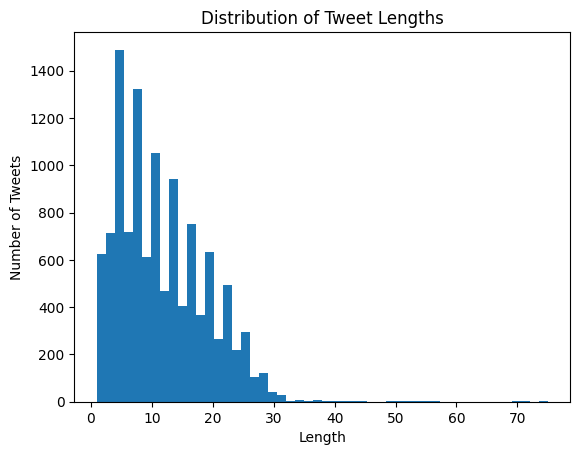

Average length: 11.622237392268964
Median length: 10.0
90th percentile length: 22.0


In [6]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt

data = pd.read_csv('UseThisClean.csv')

# Convert labels to numerical categories if they aren't already
data['Class'] = data['Class'].astype('category').cat.codes

data = data.dropna(subset=['clean_text'])
print(data['clean_text'].isnull().sum())

# Calculate lengths
tweet_lengths = data['clean_text'].apply(lambda x: len(str(x).split()))

# Plot histogram
plt.hist(tweet_lengths, bins=50)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Tweets')
plt.show()

# Print some statistics
print("Average length:", tweet_lengths.mean())
print("Median length:", tweet_lengths.median())
print("90th percentile length:", tweet_lengths.quantile(0.90))


In [4]:
from gensim.models import Word2Vec

# Load AraVec model
model_path = 'full_grams_sg_100_twitter.mdl'
aravec = Word2Vec.load(model_path)

embedding_dim = aravec.vector_size


In [5]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000  # Only consider top 10k words
max_len = 25  # Only consider the first 25 words of each tweet (Calculated average words of each tweet in previous cell)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['clean_text'])

sequences = tokenizer.texts_to_sequences(data['clean_text'])
word_index = tokenizer.word_index

# Pad sequences
X = pad_sequences(sequences, maxlen=max_len)
y = data['Class'].values

# Splitting data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in aravec.wv:
          embedding_matrix[i] = aravec.wv[word]


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()

vocab_size = 10000

# Embedding layer with pre-trained FastText weights
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True, embeddings_regularizer=l2(0.0001)))

# 1st Conv1D, BatchNorm, and MaxPooling1D layers
model.add(Conv1D(32, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(4))
model.add(Dropout(0.5))  # Increased dropout

# 2nd Conv1D, BatchNorm, and MaxPooling1D layers
model.add(Conv1D(64, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(4))
model.add(Dropout(0.5))  # Increased dropout

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(0.5))

# Final layer
model.add(Dense(3, activation='softmax'))

# Initial learning rate
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stop_on_loss = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
early_stop_on_accuracy = EarlyStopping(monitor='val_accuracy', patience=1, mode='max', restore_best_weights=True, verbose=1)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, min_lr=0.00001, verbose=1)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 25, 32)            16032     
                                                                 
 batch_normalization (BatchN  (None, 25, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 32)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             1

Epoch 1/100
469/469 [==============================] - 16s 29ms/step - loss: 11.3028 - accuracy: 0.3727 - val_loss: 9.4568 - val_accuracy: 0.5211
Epoch 2/100
469/469 [==============================] - 9s 19ms/step - loss: 8.7002 - accuracy: 0.4461 - val_loss: 7.7856 - val_accuracy: 0.5680
Epoch 3/100
469/469 [==============================] - 8s 18ms/step - loss: 7.1760 - accuracy: 0.5169 - val_loss: 6.4479 - val_accuracy: 0.6037
Epoch 4/100
469/469 [==============================] - 9s 19ms/step - loss: 5.9612 - accuracy: 0.5748 - val_loss: 5.3761 - val_accuracy: 0.6501
Epoch 5/100
469/469 [==============================] - 9s 19ms/step - loss: 4.9538 - accuracy: 0.6295 - val_loss: 4.4898 - val_accuracy: 0.6747
Epoch 6/100
469/469 [==============================] - 8s 17ms/step - loss: 4.1278 - accuracy: 0.6660 - val_loss: 3.7760 - val_accuracy: 0.6885
Epoch 7/100
469/469 [==============================] - 9s 18ms/step - loss: 3.4430 - accuracy: 0.7024 - val_loss: 3.1955 - val_accurac

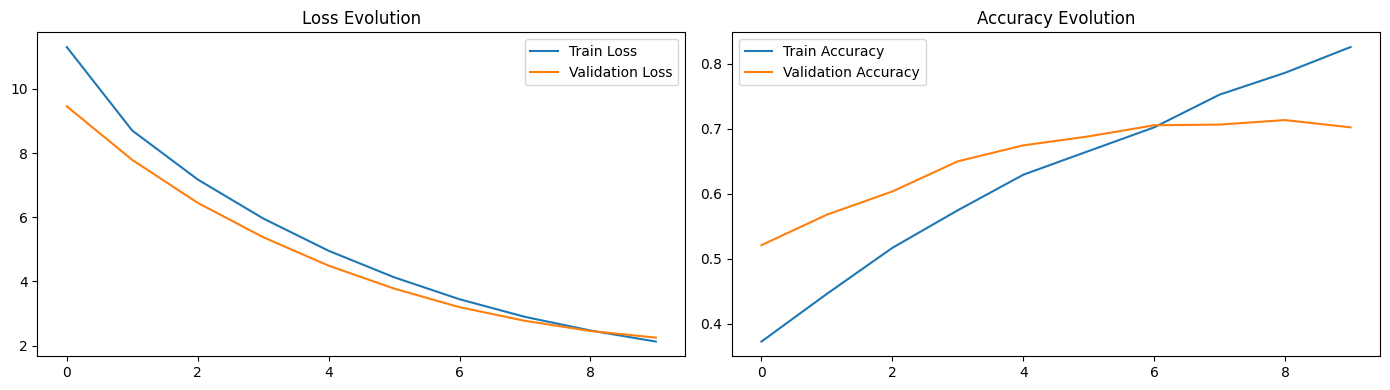

In [8]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, shuffle=True, callbacks = [early_stop_on_loss, early_stop_on_accuracy])

# Visualization of training process
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


74/74 [==============================] - 0s 3ms/step
Accuracy: 0.6825938566552902
Precision: 0.6959531416258472
Recall: 0.6876741578413714
F1 Score: 0.6856283312251414
